In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load
from sklearn.inspection import permutation_importance
import shap

In [2]:
# Load data and model
cwd = os.getcwd()
df_lgbm = pd.read_parquet(os.path.join(cwd, 'data', 'modelling', 'lgbm.parquet'))
df_lgbm.sort_index(inplace=True)
df_X = df_lgbm.drop(['goal', 'split', 'match_id', 'wyscout_id', 'statsbomb_id'], axis=1).copy()
model = load(os.path.join(cwd, 'models', 'lgbm_model.joblib'))

In [3]:
# Get feature names
features = df_X.columns
features = np.array([f.replace('_', ' ') for f in features])
features

array(['competition type', 'competition part', 'H A column',
       'match moment', 'x', 'y', 'visible angle', 'middle angle',
       'distance to goal', 'distance visible angle',
       'log distance to goal', 'shot type name', 'shot one on one',
       'shot open goal', 'under pressure', 'counter attack', 'fast break',
       'strong foot', 'body part name', 'shot number', 'shot zone number',
       'shot player number', 'shot zone player number', 'assist type',
       'pass end y', 'pass end x', 'carry length', 'pass switch',
       'pass cross', 'pass cut back', 'pass height name',
       'pass technique name', 'smart pass', 'area shot', 'area goal',
       'n angle', 'goalkeeper x', 'goalkeeper y', 'players',
       'players rival'], dtype='<U23')

In [4]:
# xg predictions. First have to fit to training data
df_lgbm['xg'] = model.predict_proba(df_X)[:, 1]
df_lgbm

,competition_type,competition_part,H_A_column,match_moment,x,y,visible_angle,middle_angle,distance_to_goal,distance_visible_angle,...,goalkeeper_x,goalkeeper_y,players,players_rival,goal,split,match_id,wyscout_id,statsbomb_id,xg
0,0,0,1,0,91.3500,42.415,0.389044,0.552452,16.0,6.224710,...,117.4,37.9,11.0,11.0,False,train,2275099,NaN,4f985308-bf76-4a5d-860c-93537b4a49e3,0.079949
1,0,2,1,0,79.6250,41.650,0.263320,0.292812,26.5,6.977976,...,119.0,41.0,11.0,11.0,False,train,7471,NaN,7e68fa7c-4e44-4b3a-ab8a-9ff1da69eacc,0.020311
2,0,1,1,0,78.7500,28.050,0.263923,0.222900,26.9,7.099534,...,119.0,40.0,11.0,11.0,False,test,19788,NaN,bfb97b05-b013-4344-83a7-da6e19b57c05,0.017808
3,1,3,0,0,84.0000,45.900,0.263764,0.515549,24.1,6.356722,...,120.0,41.0,11.0,11.0,False,train,7571,NaN,25f7433a-e83b-4960-a619-7c991b872952,0.023568
4,0,2,0,0,90.3875,20.655,0.275611,0.740093,19.8,5.457104,...,118.9,42.5,11.0,11.0,False,train,266142,NaN,aeb61371-c08d-4a3f-ad1c-6ec102a4259e,0.041223
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65549,0,0,1,5,101.8500,34.000,1.720297,0.000000,3.2,5.504950,...,NaN,NaN,10.0,11.0,True,train,2516750,182026555.0,None,0.790666
65551,0,0,0,5,91.3500,46.920,0.285946,0.757930,18.8,5.375789,...,NaN,NaN,11.0,10.0,False,test,2499739,182137485.0,None,0.046666
65552,0,0,0,5,92.4000,27.200,0.448630,0.494887,14.3,6.415413,...,NaN,NaN,11.0,10.0,False,train,2516750,182026562.0,None,0.103270
65553,0,0,0,5,93.4500,20.400,0.270438,0.866729,17.8,4.813802,...,NaN,NaN,11.0,11.0,False,train,2499820,203362910.0,None,0.091441


In [5]:
# Get a datafrane if the uncalibrated/ calibrated probabilities for each of the three models
models = model.calibrated_classifiers_
estimators = [model.base_estimator for model in models]
probabilities = []
for i in range(3):
    probabilities.append(estimators[i].predict_proba(df_X)[:, 1])
    probabilities.append(models[i].predict_proba(df_X)[:, 1])
df_probabilities = pd.DataFrame(np.vstack(probabilities).T, columns=['uncalibrated0', 'calibrated0',
                                                                     'uncalibrated1', 'calibrated1',
                                                                     'uncalibrated2', 'calibrated2'])

df_probabilities['calibrated'] = model.predict_proba(df_X)[:, 1]
df_probabilities

,uncalibrated0,calibrated0,uncalibrated1,calibrated1,uncalibrated2,calibrated2,calibrated
0,0.061041,0.062291,0.055159,0.059028,0.114096,0.118527,0.079949
1,0.016283,0.024404,0.010298,0.013026,0.012663,0.023504,0.020311
2,0.011210,0.017677,0.006496,0.009479,0.015099,0.026270,0.017808
3,0.011663,0.017677,0.024173,0.026757,0.021094,0.026270,0.023568
4,0.053396,0.055970,0.017824,0.026757,0.039141,0.040943,0.041223
...,...,...,...,...,...,...,...
64501,0.834611,0.800000,0.816485,0.870968,0.760390,0.701031,0.790666
64502,0.050373,0.045588,0.044116,0.056402,0.034312,0.038008,0.046666
64503,0.088149,0.091104,0.127988,0.109864,0.109708,0.108844,0.103270
64504,0.055045,0.056738,0.111904,0.109864,0.090036,0.107722,0.091441


In [6]:
# Shap values from shap package (estimate as probabilites rather than log odds deviation from bias). 
# Done in loop for the estimators in the calibrated classifier

# this takes a while, but calculates the contributions as probabilities
# https://github.com/slundberg/shap/issues/963
sample = data=df_X.sample(500).astype(np.float32)
contributions = []
for estimator in estimators:
    explainer = shap.TreeExplainer(estimator, data=sample, model_output='probability')
    shap_values_probability = explainer.shap_values(df_X)
    bias = explainer.expected_value
    df_contributions_probability = pd.DataFrame(shap_values_probability, columns=features)
    df_contributions_probability['bias'] = bias
    contributions.append(df_contributions_probability)

100%|===================| 64500/64506 [18:12<00:00]        

In [7]:
# Scale the uncalibrated contributions to sum to the calibrated predicted probability
scaled_contributions = []
for i in range(3):
    scaled = (contributions[i]
              .divide(df_probabilities[f'uncalibrated{i}'], axis=0)
              .multiply(df_probabilities[f'calibrated{i}'], axis=0))
    scaled_contributions.append(scaled)   
df_scaled_contributions = (scaled_contributions[0] + scaled_contributions[1] + scaled_contributions[2])/3.

In [8]:
# Remove a few where the scaled contributions don't match the actual xg
df_base = df_lgbm[['match_id', 'wyscout_id', 'statsbomb_id', 'xg']]
print(df_scaled_contributions.shape)
print(df_base.shape)

(64506, 41)
(64506, 4)


In [9]:
# Where scaled contributions not within 5 decimal places of the Xg value set to missing (some rounding errors)
df_scaled_contributions.reset_index(drop=True, inplace=True)
df_base.reset_index(drop=True, inplace=True)

In [10]:
mask_contributions_not_equal = ((df_scaled_contributions.sum(axis=1) - df_base.xg).abs() > 0.01)
df_scaled_contributions[mask_contributions_not_equal] = np.nan

In [11]:
# Return a dataframe with the contirubtions, match and event ids, and the contributions and xg
df_base = df_base.merge(df_scaled_contributions,
                        left_index=True,
                        right_index=True,
                        how='left',
                        validate='1:1')

In [12]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64506 entries, 0 to 64505
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   match_id                 64506 non-null  int64  
 1   wyscout_id               42663 non-null  float64
 2   statsbomb_id             21843 non-null  object 
 3   xg                       64506 non-null  float64
 4   competition type         64210 non-null  float64
 5   competition part         64210 non-null  float64
 6   H A column               64210 non-null  float64
 7   match moment             64210 non-null  float64
 8   x                        64210 non-null  float64
 9   y                        64210 non-null  float64
 10  visible angle            64210 non-null  float64
 11  middle angle             64210 non-null  float64
 12  distance to goal         64210 non-null  float64
 13  distance visible angle   64210 non-null  float64
 14  log distance to goal  

In [13]:
# Save the dataframe
df_base.to_parquet(os.path.join(cwd, 'data', 'modelling', 'xg_shap.parquet'))

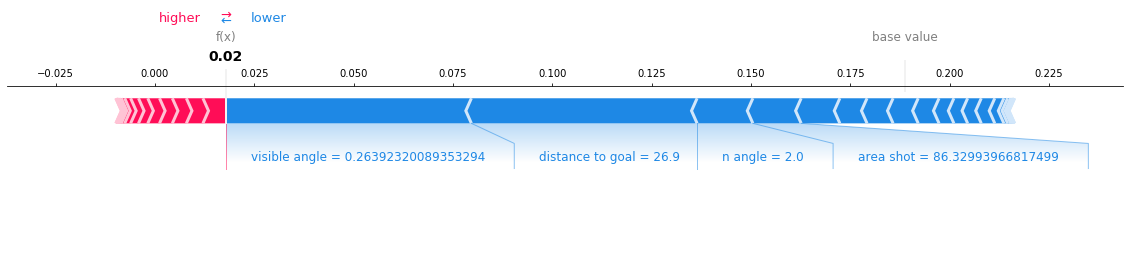

<Figure size 432x288 with 0 Axes>

In [14]:
# Use Shap to plot a contribution
idx=2
shap.force_plot(df_scaled_contributions.iloc[idx, -1], 
                df_scaled_contributions.iloc[idx, :-1].values,
                features=df_X.iloc[idx].values,
                feature_names=features, matplotlib=True, show=True)
fig = plt.gcf()
fig.savefig(os.path.join(cwd, 'figures', '08_shap_example.png'), bbox_inches = 'tight', pad_inches = 0.2)